In [1]:
#ds=xr.Dataset({'zKa':(['time','height'],np.array(zKaL)),'zKu':(['time','height'],np.array(zKuL)),'zW':(['time','height'],np.array(zWL)),'h':(['time','height'],np.array(hL)),'lon':(['time'],np.array(lonL)),'lat':(['time'],np.array(latL)),},coords={'time':t_corr[n1:n2],'height':h01[ah],'vDopKu':(['time','height'],np.array(vdopKuL)),'timeL':(['time'],np.array(timeSubL))})
#!ls IMPACTS
#'IMPACTS2022_20220203_%i_%i.nc'%(n1,n2)
import glob
fs=sorted(glob.glob("Subsets/IMPACTS*.nc"))
print(fs)

['Subsets/IMPACTS2022_20220203_1000_4000.nc', 'Subsets/IMPACTS2022_20220208_14200_17000.nc', 'Subsets/IMPACTS2022_20220208_9200_10800.nc', 'Subsets/IMPACTS2022_20230217_1000_4000.nc', 'Subsets/IMPACTS2022_20230217_13900_16600.nc', 'Subsets/IMPACTS2022_20230217_17750_19300.nc', 'Subsets/IMPACTS2022_20230217_5300_12700.nc']


In [4]:
import netCDF4 as nc 
import numpy as np
fname=fs[4]
with nc.Dataset(fname) as f:
    print(f.variables.keys())
    zKa=f.variables['zKa'][:]
    zKu=f.variables['zKu'][:]
    zW=f.variables['zW'][:]
    h=f.variables['h'][:]
    lon=f.variables['lon'][:]
    lat=f.variables['lat'][:]
    time=f.variables['time'][:]
    vdopKu=f.variables['vDopKu'][:]
    timeL=f.variables['timeL'][:]

dict_keys(['zKa', 'zKu', 'zW', 'h', 'lon', 'lat', 'time', 'height', 'vDopKu', 'timeL'])


(2700,) (2700,) (2700, 429)


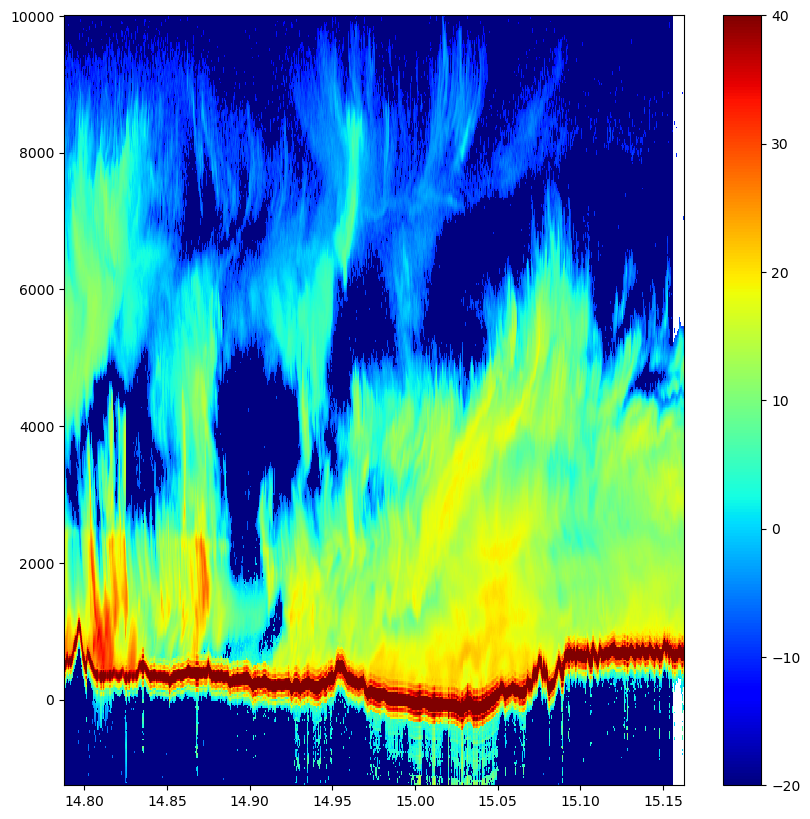

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
print(timeL.shape,h[:,0].shape,zKa.shape)
c=plt.pcolormesh(timeL,h[0,:],zKa.T,cmap='jet',vmin=-20,vmax=40)
plt.colorbar(c)

[0.10283134 0.19948269 0.30267792 0.39952448 0.50262665 0.59371749
 0.70236685 0.79900479 0.90224919 0.99882539 1.1022852  1.19855819
 1.30194896 1.39926082 1.5007759  1.59885618 1.69993617 1.79880442
 1.90072285 1.99850306 2.10112741 2.19781467 2.30049982 2.39727216
 2.49994444 2.59682104 2.69895963 2.79575626 2.89825624 2.99502463
 3.09733872 3.1933566  3.29641786 3.39322196 3.49542661 3.5918077
 3.69440632 3.79072812 3.89303535 3.9895939  4.09200241 4.18845139
 4.29076826 4.38688193 4.48878923]


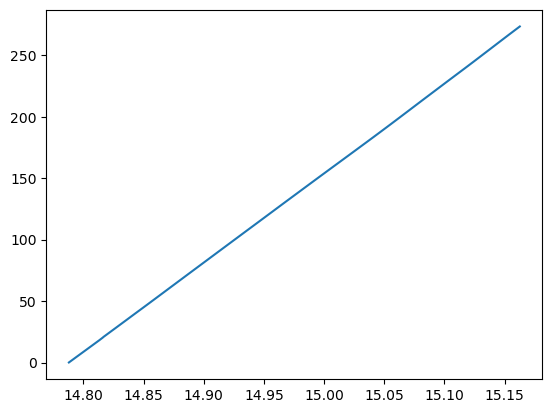

In [6]:
# calculate the distance between two points on the earth's surface

def distance(lat1, lon1, lat2, lon2):
    #print(lat1,lon1,lat2,lon2)
    # use harvesine formula
    r = 6371 # radius of earth in km
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return r * c
distL=[]

for i in range(1,len(lon)):
    distL.append(distance(lat[i-1],lon[i-1],lat[i],lon[i]))
plt.plot(timeL[1:],np.cumsum(distL))
dist_cum=np.cumsum(distL)
print(dist_cum[:45])

In [7]:
fov_dt_microw=4.5

distL=np.array(distL)
ndpr=distL.shape[0]//51
zKa_dprL=[]
zKu_dprL=[]
vDop_dprL=[]
hLT=[]
for i in range(ndpr):
    FWHMx=fov_dt_microw
    d1=distL[i*51:(i+1)*51].cumsum()
    ddx=d1-d1[25]
    #print(ddx)
    y2=((ddx/FWHMx)**2*np.log(2.))
    beam_w=np.exp(-y2)
    beam_w=beam_w/beam_w.sum()
    gain=beam_w**2
    gain=gain/gain.sum()
    zKu_avg=np.zeros((zKu.shape[1]),float)
    zKa_avg=np.zeros((zKa.shape[1]),float)
    vDop_avg=np.zeros((vdopKu.shape[1]),float)  

    for j in range(51):
        a=np.nonzero(zKu[i*51+j,:].data!=zKu[i*51+j,:].data)
        zKu[i*51+j,a]=-99.9
        a=np.nonzero(zKa[i*51+j,:].data!=zKa[i*51+j,:].data)
        zKa[i*51+j,a]=-99.9
        #print(zKu[i*51+j,:])
        zKu_avg+=10**(0.1*zKu[i*51+j,:])*gain[j]
        zKa_avg+=10**(0.1*zKa[i*51+j,:])*gain[j]
        vDop_avg+=vdopKu[i*51+j,:]*gain[j]
    hLT.append(h[i*51+25,:])
    zKu_dprL.append(10*np.log10(zKu_avg))
    zKa_dprL.append(10*np.log10(zKa_avg))
    vDop_dprL.append(vDop_avg)
    #break

(52, 429)
(52,) (53,)
(52, 429)
zku (52, 429)
hlt (52, 429)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/3891479240.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKu_dpr_m[:,::-1][:,::5],cmap='jet',vmin=10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/3891479240.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/3891479240.py:48: UserWarning: The input coordinates to pcolormesh are i

Subsets/IMPACTS2022_20230217_13900_16600.nc


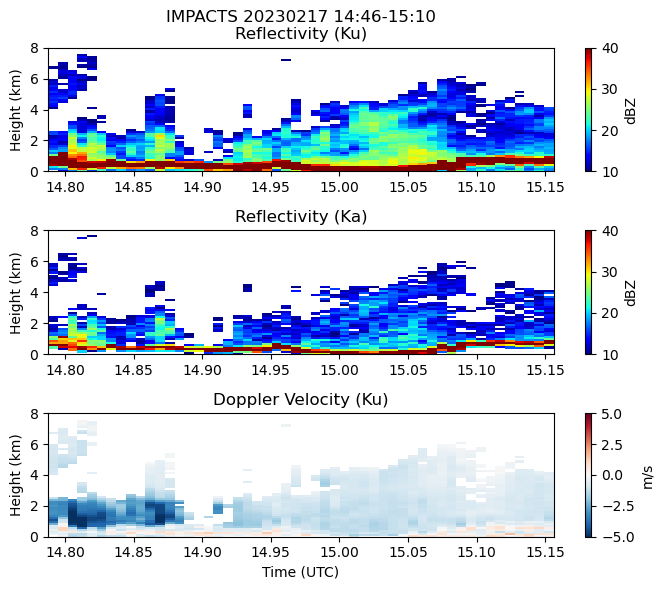

In [51]:
#plt.plot(gain)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,6))
hLT=np.array(hLT)
zKu_dpr=np.array(zKu_dprL)
zKa_dpr=np.array(zKa_dprL)
n1=np.random.randn(zKu_dpr.shape[0],zKu_dpr.shape[1])
n2=np.random.randn(zKa_dpr.shape[0],zKa_dpr.shape[1])*2
zKu_dpr_m=np.ma.masked_where(zKu_dpr+n1<10,zKu_dpr+n1)
zKa_dpr_m=np.ma.masked_where(zKa_dpr+n2<10,zKa_dpr+n2)

print(hLT.shape)
x=range(zKu_dpr_m.shape[0])
print(np.array(x).shape,timeL[25::51].shape)
#stop
x=timeL[25::51]
x2D=np.array([x[:-1] for k in range(zKu_dpr_m.shape[1])])
print(x2D.T.shape)
print('zku',zKu_dpr_m.shape)
print('hlt',hLT.shape)
from mpldatacursor import datacursor
coords = []


ax=plt.subplot(3,1,1)
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKu_dpr_m[:,::-1][:,::5],cmap='jet',vmin=-10,vmax=40)
#plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=10,vmax=40)
ax.set_title('IMPACTS 20230217 14:46-15:10\nReflectivity (Ku)')
ax.set_ylabel('Height (km)')
plt.ylim(0,8)


#datacursor()
#get coordinates from the plot using the cursor

plt.colorbar(label='dBZ')
ax=plt.subplot(3,1,2)
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=-10,vmax=40)
ax.set_title('Reflectivity (Ka)')
ax.set_ylabel('Height (km)')
plt.ylim(0,8)
plt.colorbar(label='dBZ')

ax3=plt.subplot(3,1,3)
vDop_dprL=np.array(vDop_dprL)
vDop_dpr_m=np.ma.masked_where(vDop_dprL<-8,vDop_dprL)
vDop_dpr_m=np.ma.masked_where(zKu_dpr+n1<10,vDop_dprL)   
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],vDop_dpr_m[:,::-1][:,::5],cmap='RdBu_r',vmin=-5,vmax=5)
ax3.set_title('Doppler Velocity (Ku)')
ax3.set_xlabel('Time (UTC)')
ax3.set_ylabel('Height (km)')
plt.ylim(0,8)
plt.colorbar(label='m/s')
plt.tight_layout()
plt.savefig('gmp_resolution_obs_Case5_sameScale.png',dpi=300)
print(fname)

In [28]:
print(timeL[0],timeL[-1])
print(78/100*60)
print(16/100*60)

14.78777777777782 15.162638888888978
46.800000000000004
9.6


(52, 429)
(52, 429)
zku (52, 429)
hlt (52, 429)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/1465663649.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2Df.T[:,::5],(h/1e3)[:,::5],zKum[:,::-1][:,::5],cmap='jet',vmin=-10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/1465663649.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2Df.T[:,::5],(h/1e3)[:,::5],zKam[:,:][:,::5],cmap='jet',vmin=-10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_71146/1465663649.py:48: UserWarning: The input coordinates to pcolormesh are interpreted

Subsets/IMPACTS2022_20230217_13900_16600.nc


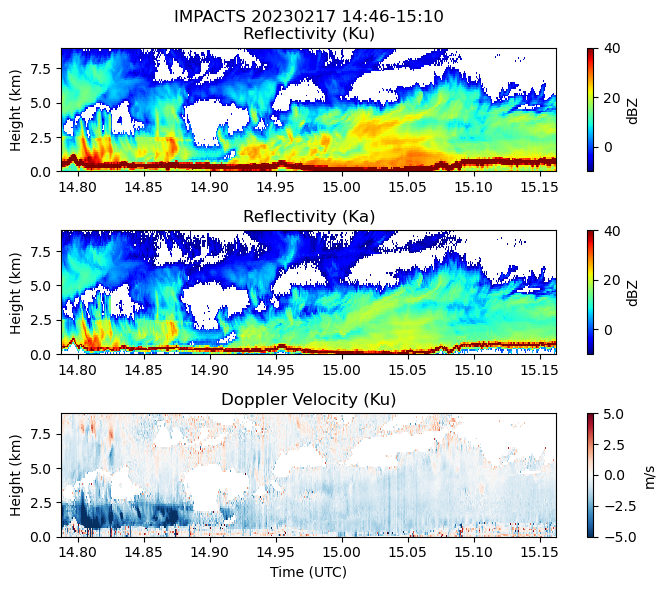

In [46]:
#plt.plot(gain)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,6))
hLT=np.array(hLT)
zKu_dpr=np.array(zKu_dprL)
zKa_dpr=np.array(zKa_dprL)
n1=np.random.randn(zKu_dpr.shape[0],zKu_dpr.shape[1])
n2=np.random.randn(zKa_dpr.shape[0],zKa_dpr.shape[1])*2
zKu_dpr_m=np.ma.masked_where(zKu_dpr+n1<10,zKu_dpr+n1)
zKa_dpr_m=np.ma.masked_where(zKa_dpr+n2<10,zKa_dpr+n2)

print(hLT.shape)
x=range(zKu_dpr_m.shape[0])
x2D=np.array([x for k in range(zKu_dpr_m.shape[1])])
print(x2D.T.shape)
print('zku',zKu_dpr_m.shape)
print('hlt',hLT.shape)
from mpldatacursor import datacursor
coords = []


ax=plt.subplot(3,1,1)
x2Df=[timeL for k in range(zKu.shape[1])]
x2Df=np.array(x2Df)
zKum=np.ma.masked_where(zKu<-10,zKu)
plt.pcolormesh(x2Df.T[:,::5],(h/1e3)[:,::5],zKum[:,::-1][:,::5],cmap='jet',vmin=-10,vmax=40)
#plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=10,vmax=40)
ax.set_title('IMPACTS 20230217 14:46-15:10\nReflectivity (Ku)')
plt.ylim(0,9)
ax.set_ylabel('Height (km)')

#datacursor()
#get coordinates from the plot using the cursor

plt.colorbar(label='dBZ')
ax=plt.subplot(3,1,2)
zKam=np.ma.masked_where(zKa<-10,zKa)
plt.pcolormesh(x2Df.T[:,::5],(h/1e3)[:,::5],zKam[:,:][:,::5],cmap='jet',vmin=-10,vmax=40)
ax.set_title('Reflectivity (Ka)')
plt.ylim(0,9)
ax.set_ylabel('Height (km)')
plt.colorbar(label='dBZ')

ax3=plt.subplot(3,1,3)
vDop_dprL=np.array(vDop_dprL)
vDop_dpr_m=np.ma.masked_where(vDop_dprL<-8,vDop_dprL)
vDop_dpr_m=np.ma.masked_where(zKu_dpr+n1<10,vDop_dprL)   
plt.pcolormesh(x2Df.T[:,::5],(h/1e3)[:,::5],vdopKu[:,::-1][:,::5],cmap='RdBu_r',vmin=-5,vmax=5)
ax3.set_title('Doppler Velocity (Ku)')
ax3.set_ylabel('Height (km)')
ax3.set_xlabel('Time (UTC)')
plt.ylim(0,9)
plt.colorbar(label='m/s')
plt.tight_layout()
plt.savefig('fine_resolution_obs_Case5.png',dpi=300)
print(fname)

26.25
[]


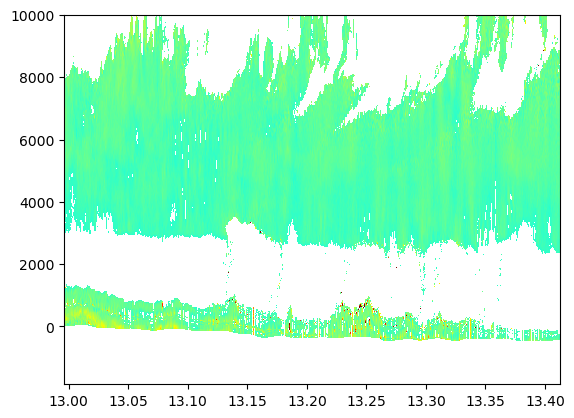

In [8]:
print(hLT[0,0]-hLT[0,1])
print(coords)
vdopKu_m=np.ma.masked_where(vdopKu<-2,vdopKu)
plt.pcolormesh(timeL,h[0,:],vdopKu_m[:,::-1].T,cmap='jet',vmin=-10,vmax=10)